# Прогнозирование оттока клиентов сети фитнес-центров

## Цель

Основная задача проекта - спрогнозировать, какие пользователи могут перестать посещать тренажерный зал, чтобы вовремя предложить им поддержку или мотивацию. 
Для анализа предоставлены  клиентские данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Для выполнения поставленной задачи реализую следующие шаги:
- выделю типичные портреты пользователей, 
- определю ключевые факторы, влияющие на отток, 
- предложу рекомендации по удержанию клиентов и улучшению взаимодействия с ними.

## Импорт необходимых библиотек

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings

# Улучшение четкости изображения
%config InlineBackend.figure_format = 'retina'

#отключение предупреждений
warnings.filterwarnings('ignore')

# фунция для обучения моделей и расчета метрик accuracy, precision и recall
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('* Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('* Precision: {:.2f}'.format(precision_score (y_test, y_pred)))
    print('* Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('* F1: {:.2f}'.format(f1_score(y_test, y_pred)))

## Обзор данных

Заказчик подготовил данные, которые содержат информацию о клиентах на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:
- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе фитнес-центра;
- 'Partner' — сотрудник компании-партнёра клуба;
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга»;
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах);
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра;
- 'Churn' — факт оттока в текущем месяце.

Сохраним данные в переменной df, просмотрим общую информацию о данных и первые 5 строк датасета.

In [2]:
# чтение файла и создание датафрейма
try:
    df = pd.read_csv('/datasets/gym_churn.csv')
except:
    df = pd.read_csv('gym_churn.csv')

In [3]:
# вывод общей информации о датасете
df.info()
# вывод первых 5 строк датасета
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


В исходном датасете записи о 4000 клиентов, этих данных достаточно для выполнения поставленной задачи. Пропусков в данных нет, типы данных можно сотавить без изменений. 

Для удобства дальнейшей работы приведем названия столбцов к нижнему регистру.

In [4]:
# приведение названий столбцов к нижнему регистру
df.columns = df.columns.str.lower()

<b>Промежуточный вывод</b>

1. Изучена общая информация о датасете.
2. Названия столбцов датасета приведены к нижнему регистру.

## Исследовательский анализ данных

### Средние значения и стандартные отклонения в датасете

Изучим данные подробнее. Для этого выведем информацию о средних значениях и стандартных отклонениях.

In [5]:
# вывод информвции о средних значениях и стандартных отклонениях
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


На основании информации таблицы можно сделать следующие выводы:
1. В данных практически равное количество мужчин и женщин - 49% и 51%.
2. Большинство клиентов живет или работает рядом с фитнес-центром - 84,5%.
3. Почти половина клиентов являются сотрудниками компаний-партнеров - 48,7%, и 30,85% посетителей пришли в фитнес-центр по акции приведи друга. Это указывет на то, что программы «приведи друга» и партнёрства работают, их стоит развивать.
4. В среднем клиенты остаются на протяжении 4-5 месяцев, около 25% клиентов остаются в клубе более 6 месяцев, однако половина пользователей покидает клуб после 1-го месяца. Это указывает на повышенны риск оттока новых клиентов.
5. Фитнес-центры клуба посещают клиенты в возрасте от 18 до 41 года, большинство клиентов в возрасте от 27 до 31 лет.
6. На дополнительные услуги фитнес-центров клиенты тратят от 0,15 до 552,6 у.е. (валюта в описании данных не указана), в среднем на дополнительные услуги клиенты тратят около 150 у.е. Это может указывать на интерес клиентов к дополнительным услугам и/или товарам фитнес-центров.
7. Средняя продолжительность "жизни" клиента 3,7 месяца, 25% пользователей остаются с клубом более 5 месяцев (максимум 31 месяц), это наиболее лояльные клиенты.
8. 41% клиентов посещают групповые занятия, а в среднем клиенты посещают фитнес-центры 2 раза в неделю (1,88 по вычесленным значениям), 25% пользователей посещяют клуб более 2 раз в неделю (максимум 6 раз в неделю).
9. Чуть больше четверти клиентов относятся к оттоку - 26.5%. Это довольно большой показатель. Важно выявить факторы, отличающие лояльных пользователей от уходящих, для понимания на каких пользователей делать упор в привлечении.

Посмотрим как отличаются средние значения признаков в двух группах - клиенты ушедшие в отток и оставшиеся клиенты.


### Средние значения признаков по группам

In [6]:
# вывод информации о средних значениях в разбивке по группам
df.groupby('churn').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


На основании данных выше можно сделать следующие выводы:
1. Расположение зала относительно места жительства или работы имеет значение - вероятность остаться выше у пользователей, которые живут или работают рядом с фитнес-центром.
2. Партнерские и реферальные (акция "приведи друга") программы работают и помогают удерживать клиентов.
3. Чаще уходят клиенты с короткими контрактами. В отток в основном уходят новые клиенты, "прожив" с клубом около месяца.
4. Клиенты, посещающие групповые программы, остаются в клубе дольше.
5. Чаще в отток уходят более молодые клиенты.

В итоге короткий контракт и редкие посещения — яркие индикаторы риска оттока. Участие в групповых тренировках, партнерские программы и акции вроде «приведи друга» — хорошо работают на удержание. Близость к клубу такжеимеет влияние, хотя и менее выраженное.

### Построение столбчатых гистограмм и распределений признаков по группам

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

Разделим признаки на бинарные (те, у которых может быть только два значения) и не бинарные, у которых может быть больше двух значений. Бинарные признаки можно отобразить наглядно в виде долей на одной столбчатой диаграмме.

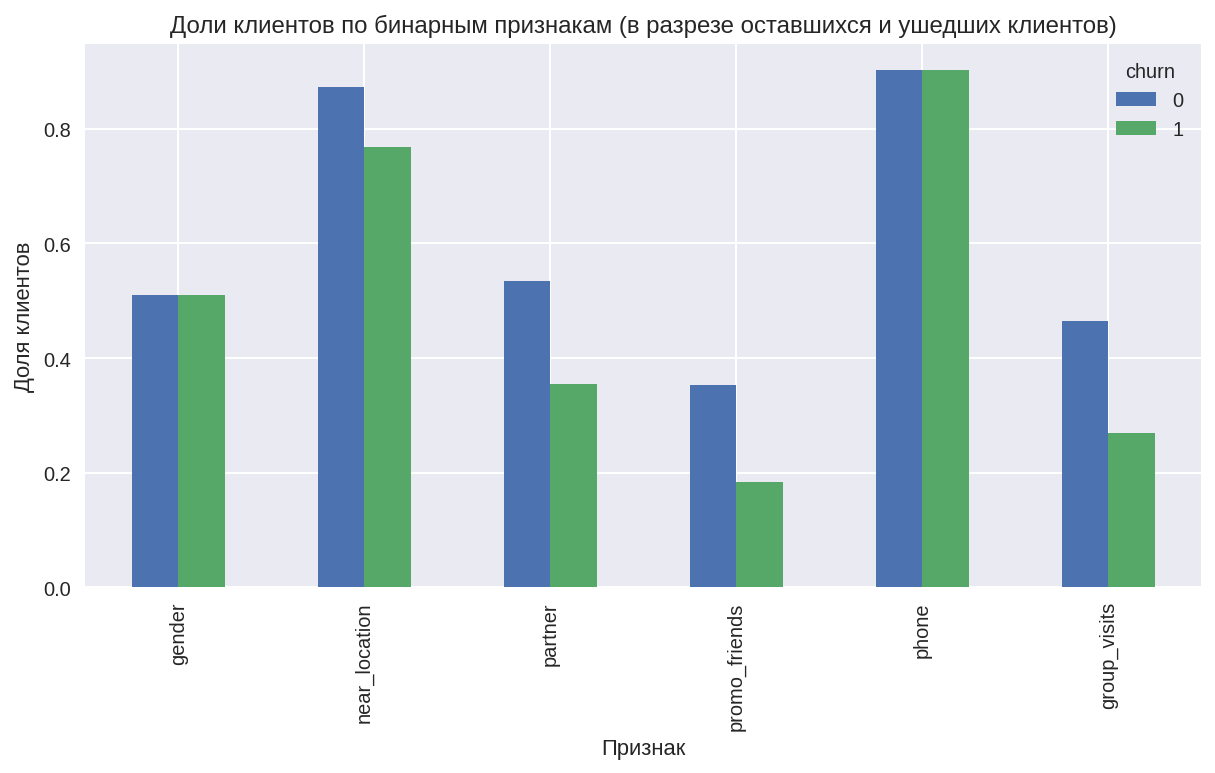

In [7]:
# выделение бинарных признаков в отдельную переменную
binary_features = ['gender','near_location','partner','promo_friends','phone','group_visits']

# построение столбчатой диаграммы
with plt.style.context('seaborn'):
    df.groupby('churn')[binary_features].agg('mean').T.plot(kind='bar', stacked=False, figsize=(10, 5))
    plt.title('Доли клиентов по бинарным признакам (в разрезе оставшихся и ушедших клиентов)')
    plt.xlabel('Признак')
    plt.ylabel('Доля клиентов')    
    plt.show()

На диграмме наглядно видна значимость партнерских программ, акций вроде "приведи друга", посещения групповых программ в удержании клиентов. Менее выраженную значимость также видно в признаке близкой локации фитнес-центра. Это подтверждает выводы, сделанные на предыдущем шаге.

Посмотрим на гистограммы и кривые распределения для небинарных признаков.

Количество тех, кто ушел в отток:  1061
Количество тех, кто остался:  2939


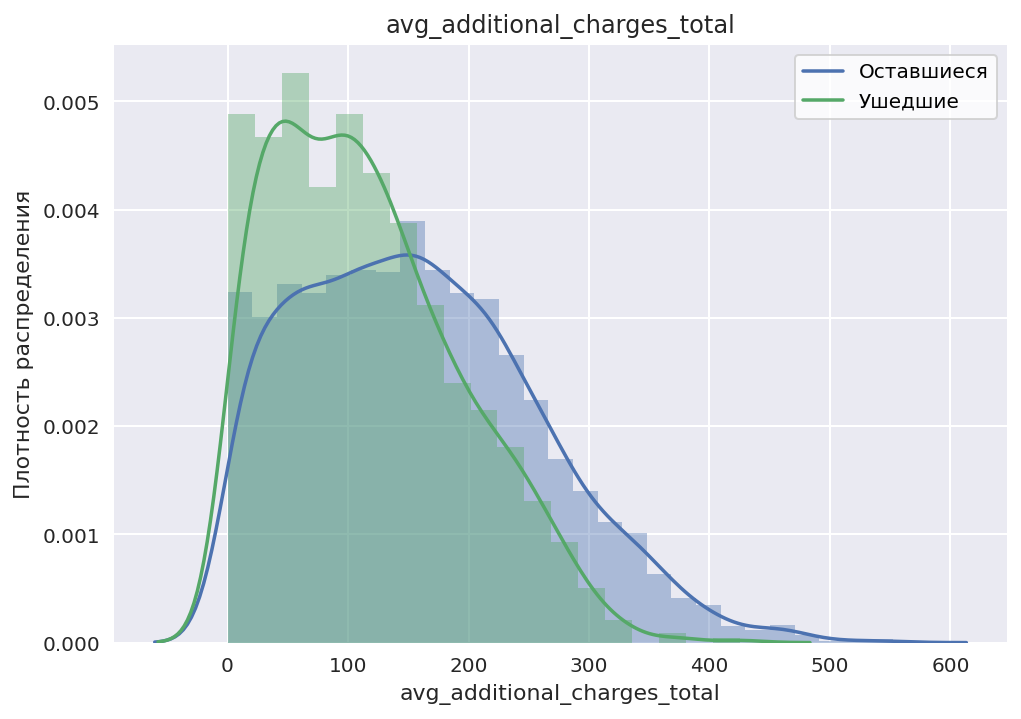

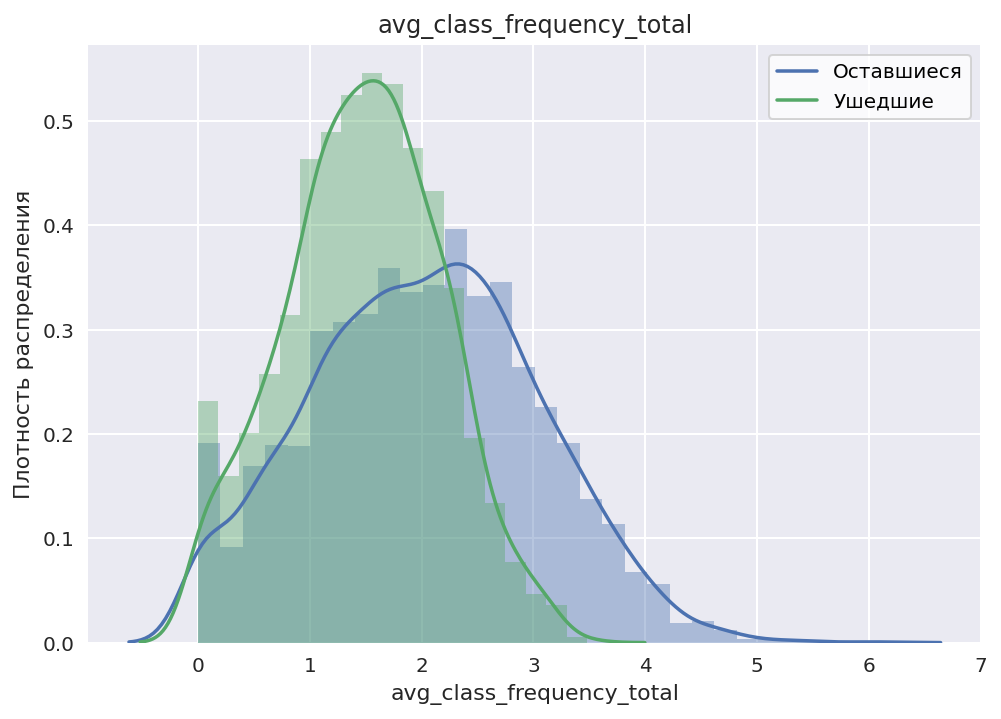

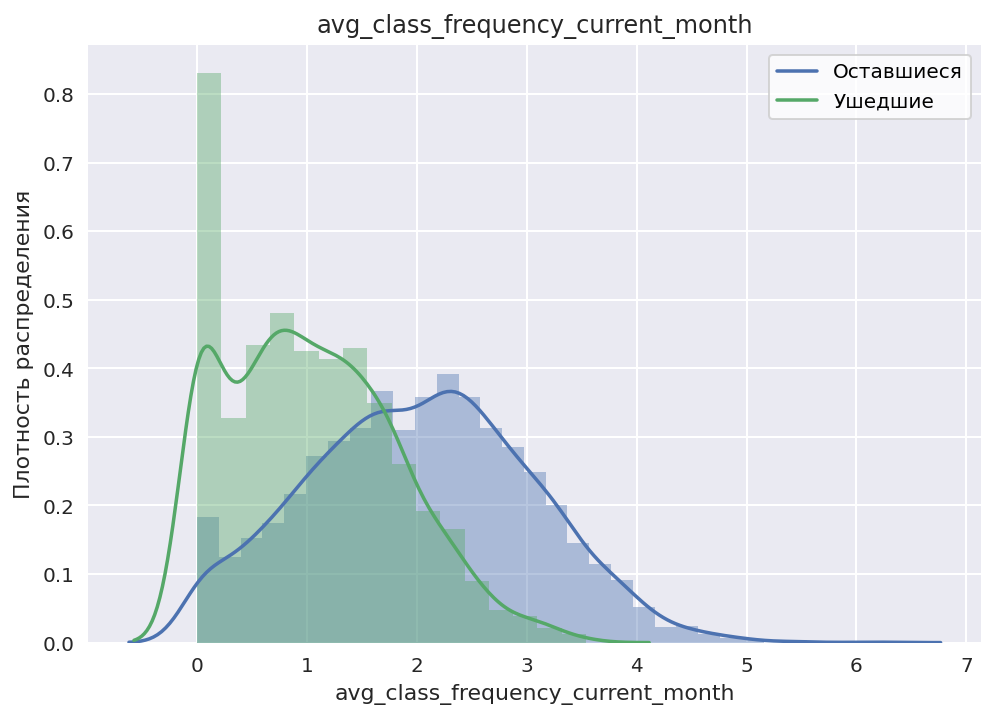

In [8]:
# cоздаем отдельные датасеты с теми, кто ушёл (отток) и теми, кто остался (не попали в отток)
churn = df[df['churn'] == 1]
retention = df[df['churn'] == 0]
print('Количество тех, кто ушел в отток: ',len(churn))
print('Количество тех, кто остался: ',len(retention))

# сохранение в отдельной переменной первой части признаков для лучшей визуализации
num_features = ['avg_additional_charges_total','avg_class_frequency_total','avg_class_frequency_current_month']

# построение гисторамм для первой части признаков
for col in num_features:
    with plt.style.context('seaborn'):
        sns.distplot(retention[col])
        sns.distplot(churn[col])
    labels= ["Оставшиеся", "Ушедшие"]
    plt.grid(True)
    plt.title(col)
    plt.legend(labels)
    plt.xlabel(col)
    plt.ylabel('Плотность распределения')
    plt.show()

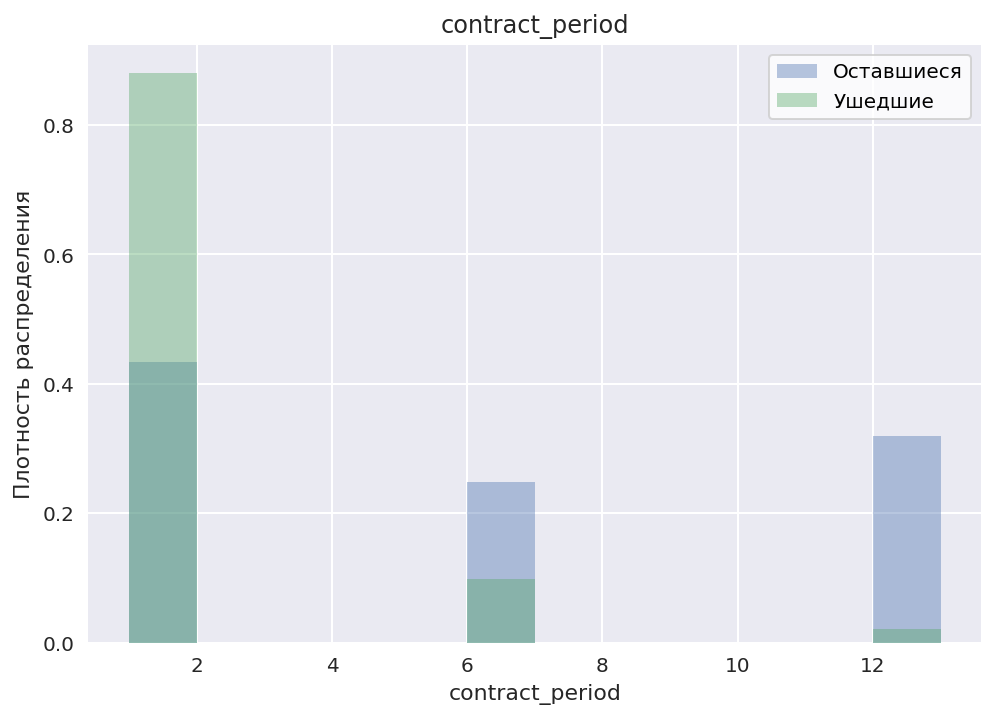

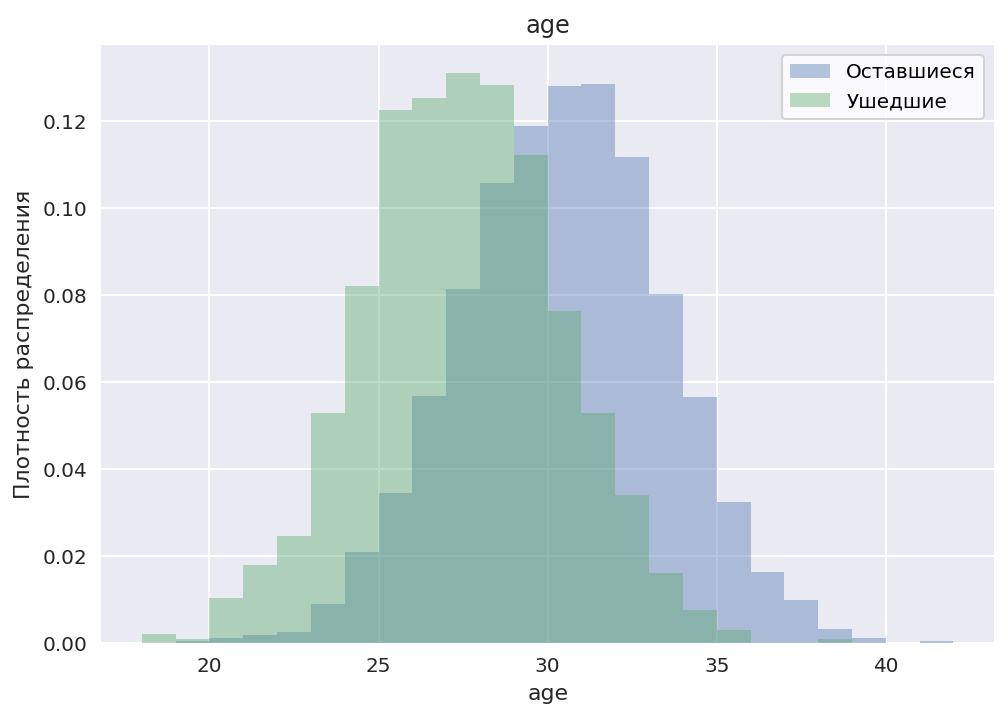

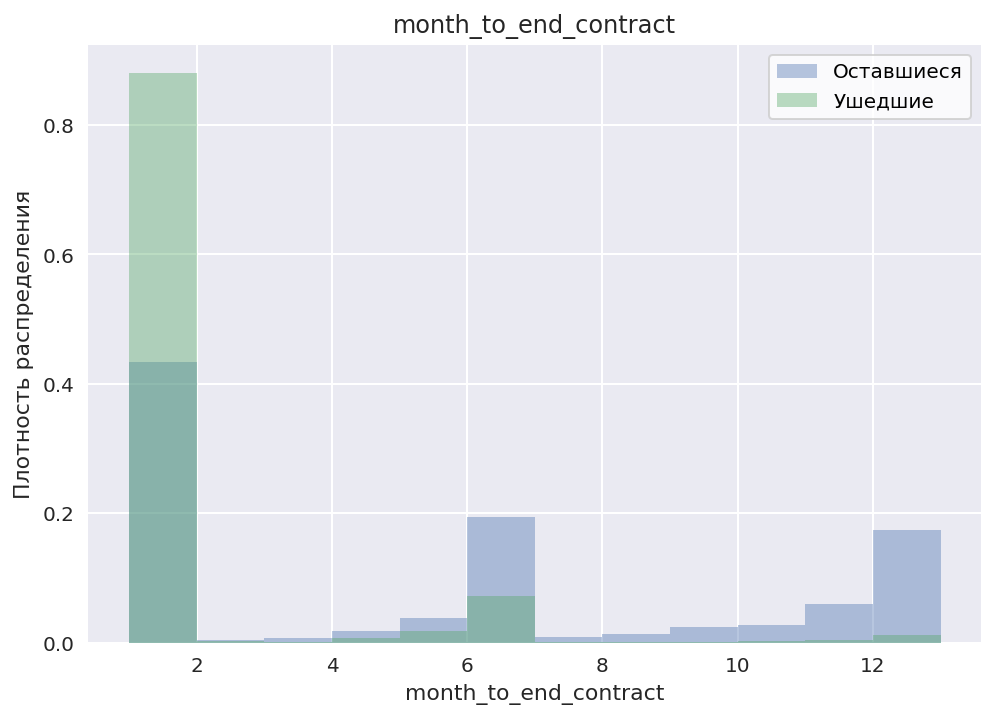

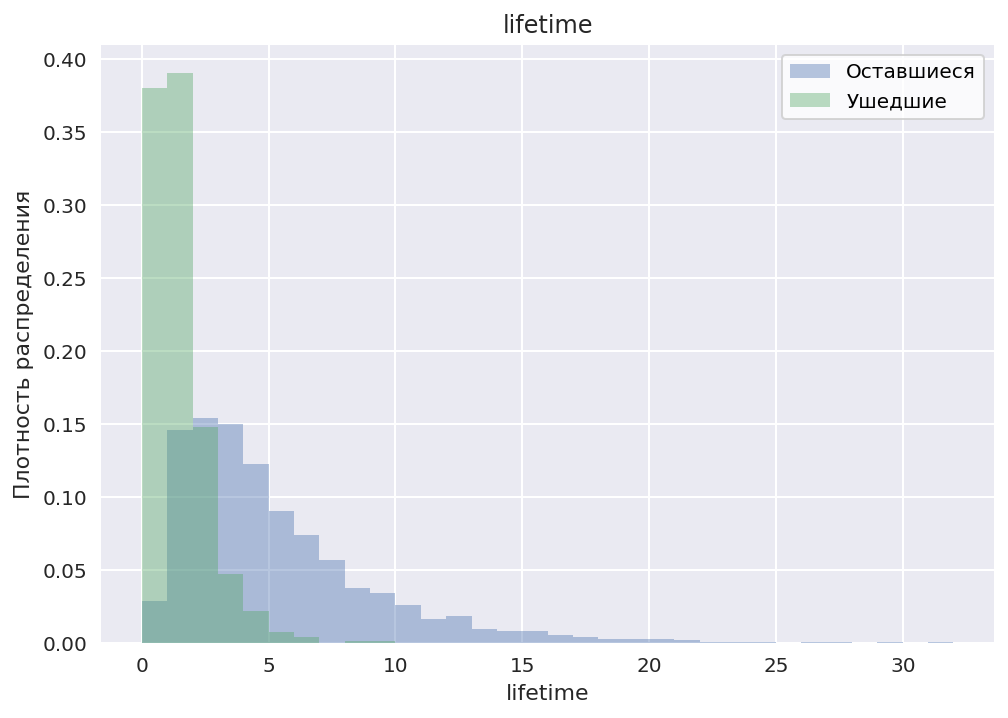

In [9]:
# сохранение в отдельной переменной второй части признаков для лучшей визуализации
num_features_2 = ['contract_period','age','month_to_end_contract','lifetime']

# построение гистограмм для второй части признаков
for col in num_features_2:
    min_value = int(min(df[col]))    
    max_value = int(max(df[col]))
    with plt.style.context('seaborn'):
        sns.distplot(retention[col], kde=False, norm_hist=True, bins = range(min_value, max_value+2), label='0')
        sns.distplot(churn[col], kde=False, norm_hist=True, bins = range(min_value, max_value+2), label='1')
    labels= ["Оставшиеся", "Ушедшие"]
    plt.grid(True)
    plt.title(col)
    plt.legend(labels)
    plt.xlabel(col)
    plt.ylabel('Плотность распределения')
    plt.show()

По данным гистограммам можно сделать следующие выводы:
1. <b>avg_additional_charges_total:</b> по гистограммам видно, что ушедшие и оставшиеся клиенты в целом схожи по использованию дополнительных услуг клуба - и те и другие довольно активно тратят деньги на дополнительные услуги. Однако видно, что оставшиеся клиенты совершают покупки чаще и с более высоким средним чеком.
2. <b>avg_class_frequency_total:</b> по гистограмме видно, что оставшиеся клиенты посещают фитнес-центры чаще и регулярнее, чем ушедшие клиенты. Это указывает на то, что регулярность посещений положительно сказывается на удержании клиентов.
3. <b>avg_class_frequency_current_month:</b> на данном графике видна аналогичная ситуация. Ушедшие пользователи реже посещали клуб в текущем месяце. Также виден всплеск нулевых значений в самом начале графика, что указывает на то, что многие ушедшие клиенты не посетили клуб ни разу. Это указывает на то, что снижение посещаемости может быть ранним сигналом возможного оттока.
4. <b>contract_period:</b> на графике видно, что большинство ушедших пользователей уходят в первые два месяца. Оставшиеся клиенты проводят в клубе 6-12 месяцев.
5. <b>age:</b> чаще клуб покидают более молодые пользователи (пик приходится на 25-28 лет), а среди оставшихса больше клиентов в возрасте старше 28 лет.
6. <b>month_to_end_contract:</b> ушедшие клиенты чаще находятся на финальных месяцах (1-2 мес) до конца контракта. Оставшиеся распределены более равномерно. Характер распределения по данному параметру очень похож на contract_period, возможно между ними есть большая корреляция.
7. <b>lifetime:</b> среди ушедших клиентов подаляющее большинство с коротким сроком жизни - 1-2 месяца. А вот оставшиеся клиентв зачастую проводят с клубом более 3-х месяцев.

Чтобы понять взаимосвязь признаков построим матрицу корреляций.

### Построение матрицы корреляций

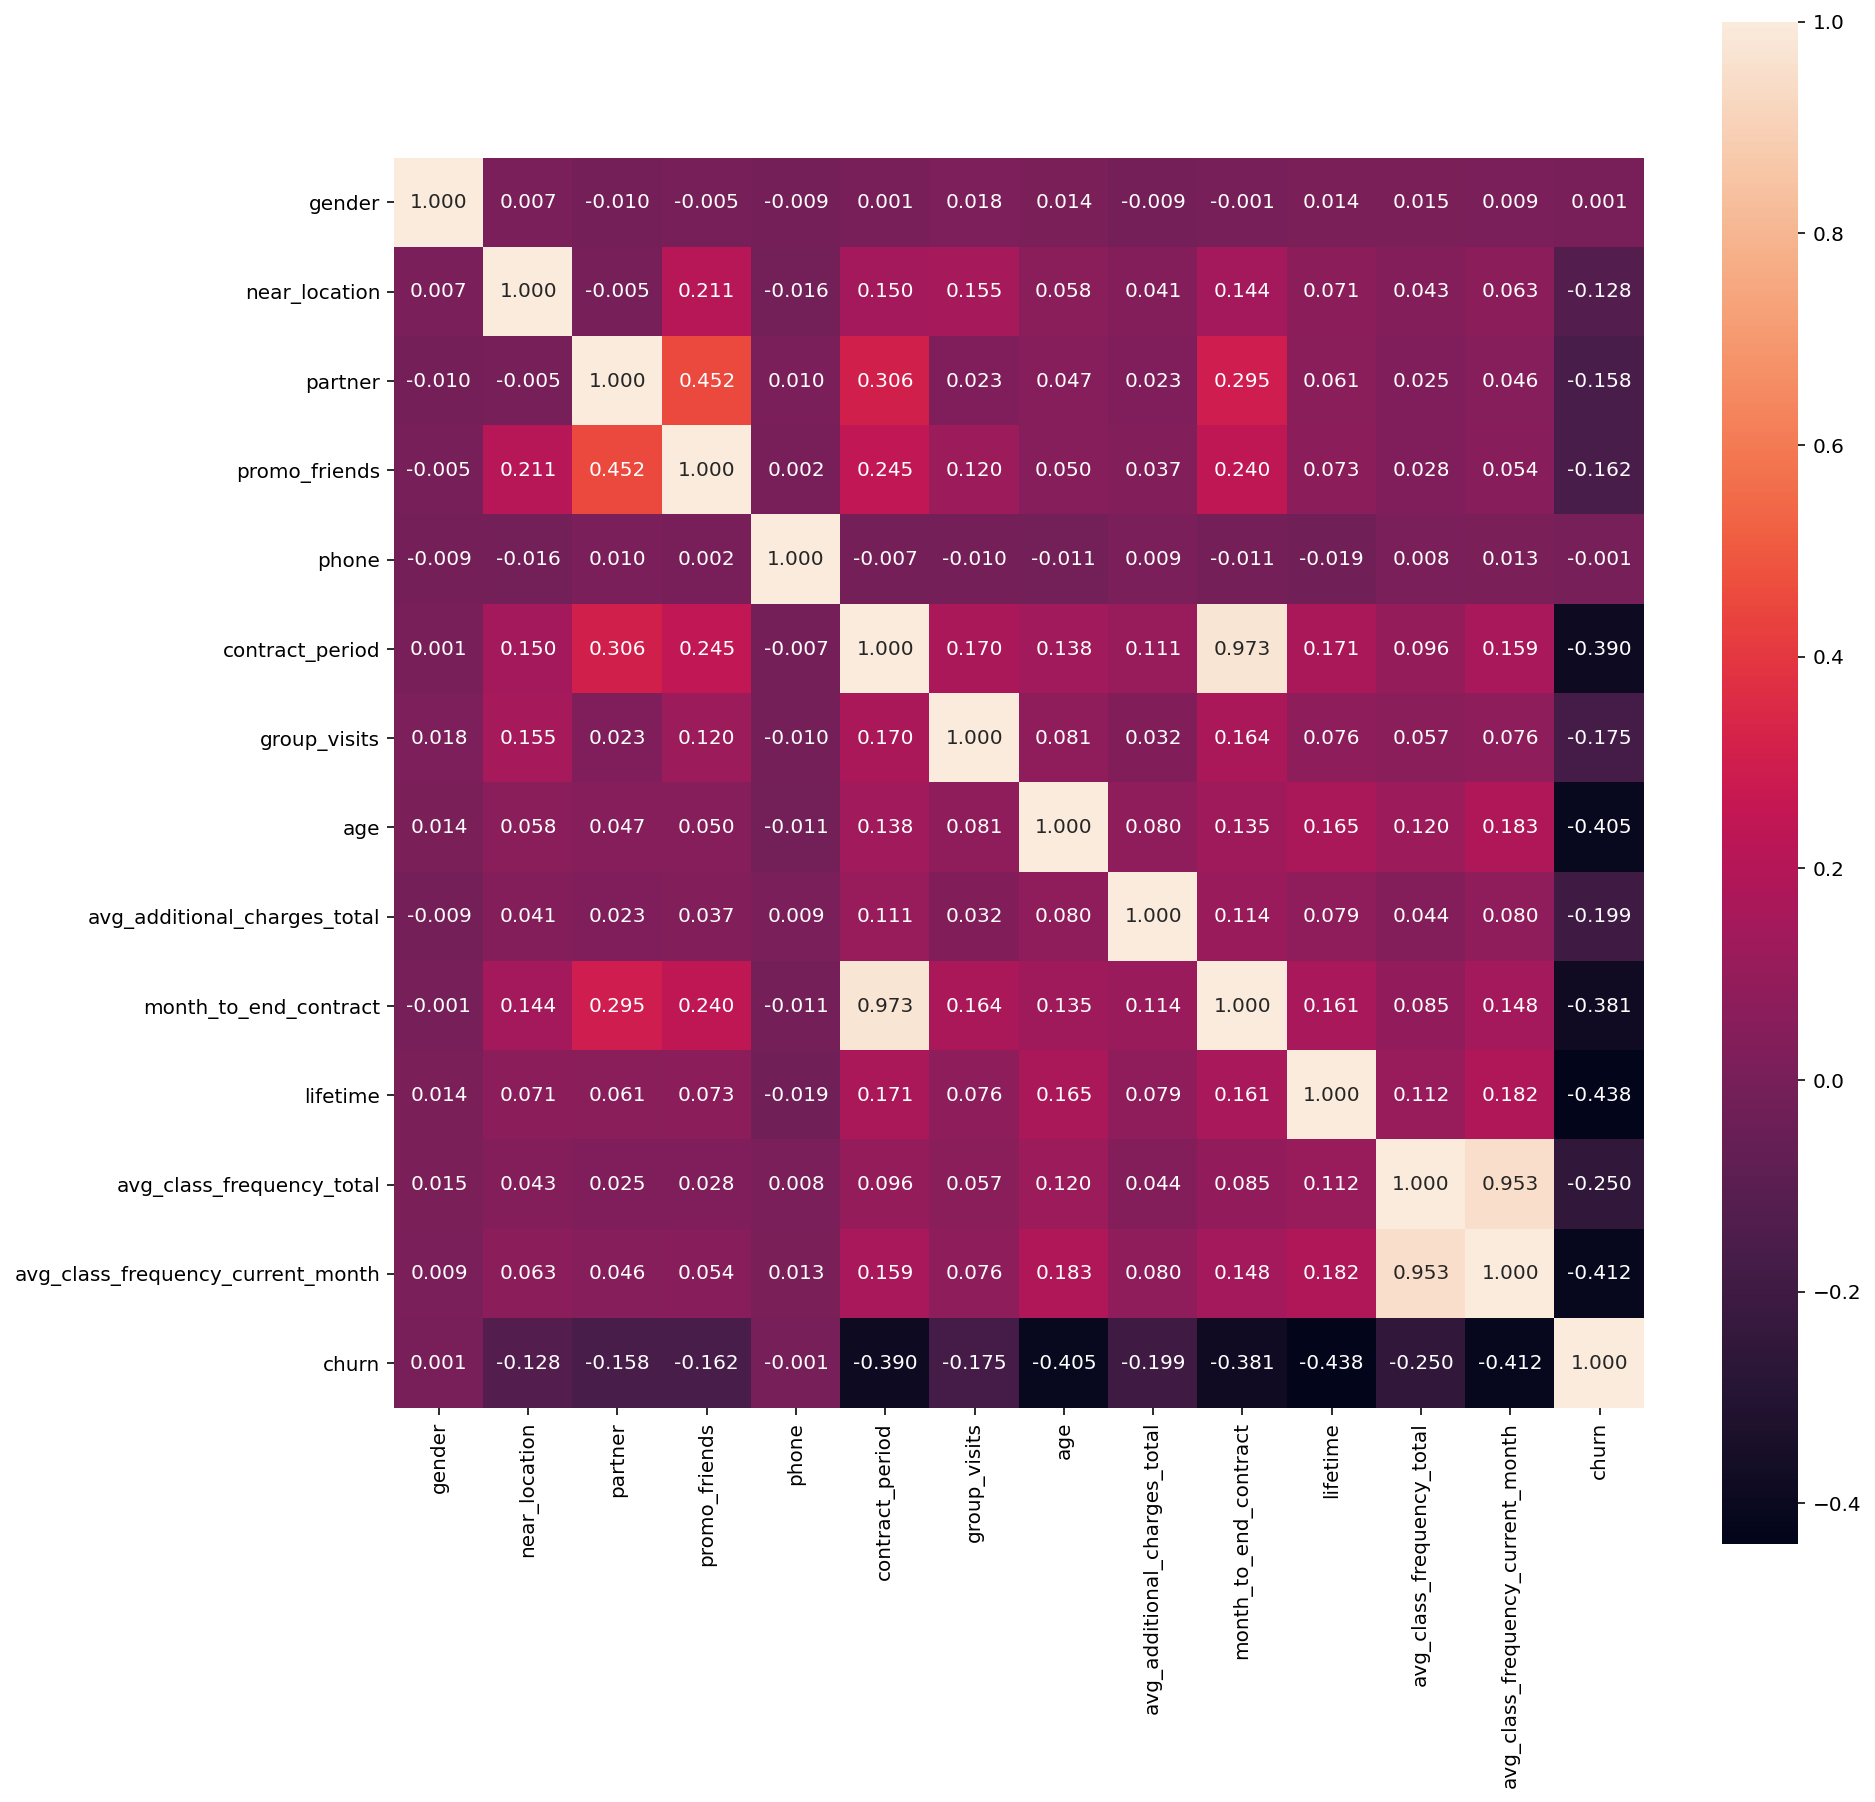

In [10]:
# формирование корреляционной матрицы
corr_m = df.corr()

# вывод матрицы на экран в виде тепловой карты (heatmap)
plt.figure(figsize = (14,14))
sns.heatmap(corr_m, square = True, annot = True, fmt=".3f")
plt.show()


Судя по матрице корреляций видно, что наиболее информативные признаки для предсказания оттока это:
- <b>lifetime</b> - чем дольше клиент с компанией, тем меньше вероятность ухода;
- <b>avg_class_frequency_current_month</b> - чем чаще клиент посещает фитнес-центры в текущем месяце, тем меньше вероятность их ухода;
- <b>age</b> - чаще уходят более молодые клиенты;
- <b>contract_period / month_to_end_contract</b> - чем меньше срок контракта и меньший срок до конца контракта, тем выше риск оттока.

Также видно, что есть две пары скоррелированнных признаков:
1. <b>avg_class_frequency_total и avg_class_frequency_current_month: 0.953</b> — почти одинаковые, можно оставить только один в модели, чтобы избежать мультиколлинеарности;
2. <b>month_to_end_contract и contract_period: 0.973</b> — тесно связаны, аналогично, стоит оставить только один.

Чтобы избежать мультиколлинеарности и получения нерепрезентативных весов и переобученной под эти признаки модель, удалим по одному из них, например, month_to_end_contract и avg_class_frequency_current_month.

In [11]:
# удаление столбцов month_to_end_contract и avg_class_frequency_current_month из датасета
df = df.drop('month_to_end_contract', axis = 1)
df = df.drop('avg_class_frequency_current_month', axis = 1)

<b>Промежуточный вывод:</b>

1. Анализ данных показал, что на удержание клиентов влияет целый ряд факторов. Большинство клиентов — молодые люди в возрасте 27–31 года, мужчин и женщин практически поровну. Более 80% живут или работают рядом с клубом, что делает фактор локации значимым, хотя и не решающим.
2. Программы лояльности, такие как участие в партнёрских акциях и акции «приведи друга», демонстрируют высокую эффективность в удержании клиентов. Также заметна связь между частотой посещения групповых занятий и снижением риска оттока — регулярные и вовлечённые пользователи реже уходят.
3. Основной риск оттока связан с новыми клиентами: около половины пользователей покидают клуб уже после первого месяца, особенно при краткосрочных контрактах. Это делает ключевым акцент на вовлечение клиентов в первые недели после подписки. Более лояльные клиенты остаются с клубом в среднем 4–5 месяцев, а наиболее лояльные — свыше 6 месяцев.
4. Также факторами риска являются низкая активность (редкие или отсутствующие посещения), молодой возраст, минимальные траты на дополнительные услуги и окончание срока контракта. Наоборот, высокая частота посещений, особенно в текущем месяце, и активное использование дополнительных сервисов — хорошие индикаторы вовлеченности.
5. Анализ корреляций показал, что на отток сильнее всего влияют следующие признаки:
 - срок жизни клиента (lifetime),
 - текущая посещаемость (avg_class_frequency_current_month),
 - возраст (age),
 - длительность и остаток контракта (contract_period, month_to_end_contract).
6. Также выявлены пары сильно скоррелированных признаков, что может привести к переобучению моделей. Для повышения качества прогнозирования были исключены дублирующие переменные - month_to_end_contract и avg_class_frequency_current_month.

## Построение модели прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. Обучим модель двумя способами - логистической регрессией и случайным лесом.

In [12]:
# делим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis = 1)
y = df['churn']

# делим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# составим список моделей
models = [LogisticRegression(max_iter=1000, random_state=0), RandomForestClassifier(random_state=0)]

for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)

LogisticRegression(max_iter=1000, random_state=0)
* Accuracy: 0.90
* Precision: 0.78
* Recall: 0.81
* F1: 0.80
RandomForestClassifier(random_state=0)
* Accuracy: 0.89
* Precision: 0.78
* Recall: 0.77
* F1: 0.78


Обе модели показывают высокое качество предсказания (F1-score выше 0.75). Однако логистическая регрессия немного превосходит случайный лес по всем метрикам, особенно по recall (чувствительности к уходящим клиентам) и F1-мере.

Высокий recall (0.81) у логистической регрессии говорит о том, что она лучше выявляет клиентов, которые с большой вероятностью уйдут.

Precision одинаков (0.78) у обеих моделей показывет, что среди тех, кого модель определила как "отток", примерно 78% действительно уходят.

## Кластеризация клиентов

Отбросим столбец с оттоком и проведем кластеризацию клиентов.

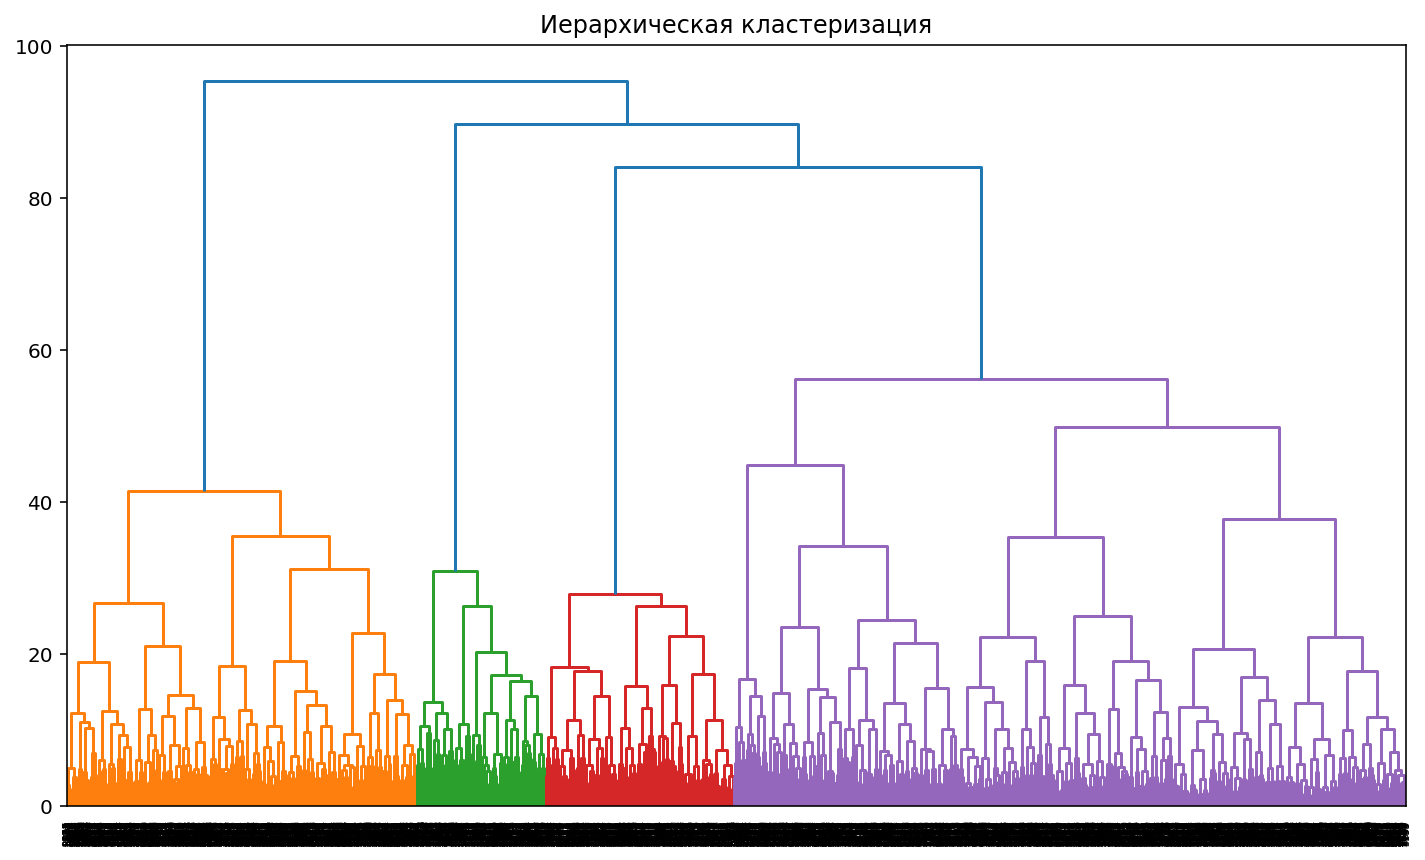

In [13]:
# создадим объект класса StandardScaler и применим его к датафрейму, отбросим столбец с оттоком
sc = StandardScaler()
x_sc = sc.fit_transform(df.drop('churn', axis = 1)) # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# В переменной linked сохраняенм таблицу «связок» между объектами. 
linked = linkage(x_sc, method = 'ward')

# Создание и визуализации дендрограммы
plt.figure(figsize=(12, 7))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show()

Судя по дендрограмме оптимальное количество кластеров 4-5. 

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров примем n=5, что согласуется с построенной дендрограммой.

In [14]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_client'] = labels

# выводим статистику по средним значениям признаков по кластеру
df.groupby(['cluster_client']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster_client,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1.0,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1.0,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1.0,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1.0,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Параметры gender и age мало отличаются во всех кластерах. Они не имеют значительного влияния на отток.

<b>Кластер 0</b>

Данный кластер имеет наиболее высокий процент оттока - 40%.
Клиенты, попавшие в данный кластер:
- живут и работают далеко от клуба (near_location = 0);
- почти нет участия в акции "приведи друга" и менее половины учавствовали в партнёрствах;
- имеют низкую вовлеченность: только 23.5% посещают групповые занятия, довольно короткий контракт (около 3-х месяцев), низкая частота посещений - 1,7 посещений в неделю.
- самый низкий средний lifetime - 3 мес.
Исходя из вышесказанного можно сделать вывод, что самый проблемный сегмент — клиенты, живущие далеко от фитнес-центров, слабо вовлечённые, пришедшие не по акционным программам.

<b>Кластер 1</b>

В данный кластер входят лояльные и вовлечённые клиенты с одним из наименьших процентов оттока - 11.7%.
Данные клиенты:
- живут или работают рядом с фитнес-центрами;
- большая часть клиентов пришла по акции "приведи друга" или партнерсокй программе;
- длинный контракт (7.66 мес);
- довольно часто посещают групповые программы;
- высокий lifetime (4.4 мес);
- довольно регулярно посещают фитнес-центры - 1.97 раза в неделю.
Из вышеперечисленного можно сделать вывод, что клиенты, входящие в кластер 1 почти все живут рядом, участвуют в партнёрской и реферальной программе, регулярно посещают фитнес-центры. Это указывает на то, что данные факторы в значительной степени влияют на удержание клиентов.

<b>Кластер 2</b>

В данный кластер входят малоактивные клиенты с высокой долей оттока -  38.16%. Данные клиенты:
- проживают и/или работают далеко от фитнес-центров;
- не участвуют в акциях;
- не посещают групповые программы;
- имеют короткий контракт (около 2.8 мес);
- имеют один из самых низких lifetime (3,34 мес.);
- имеют редкие визиты (1,8 в неделю).

Поведение клиентов из данного кластера довольно похоже на кластер 0.

<b>Кластер 3</b>

Отток клиентов данного кластера относительно небольшой - 20%. Для клиентов из данного кластера характерны:
- участие в групповых программах - все клиенты, входящие в кластер, посещают групповые программы;
- имеют одни из самых низких показателей участия в партнерских программах и акциях;
- живут рядом с фитнес-центрами;
- имеют контракт на 4.5 мес.;
- имеют хорошие показатели посещаемости - 1.94 посещения в неделю;
- lifetime 3.7 месяца.

Исходя из вышеперечисленного можно сделать вывод, что участие в групповых тренировках один из счильнейших факторов удержания.

<b>Кластер 4</b>

Отток клиентов данного кластера 26.6% — выше, чем в 1 и 3, но ниже, чем в 0 и 2. Для клиентов данного кластера характерны:
- довольно большая доля клиентов живет или работает рядом с фитнес-центрами;
- около половины клиентов участвуют в партнерсокй программе и около 30% клиентов пришли по акции "приведи друга";
- контракт имеет среднюю продолжительность 4.77 мес, что является второй по величине продолжительностью контракта реди всех кластеров;
- lifetime составляет 3.94 мес, и это второй по величине lifetime среди всех кластеров
- средняя посещаемость фитнес ценров в неделю.

Клиенты из данного кластера требуют дополнительной работы по удержанию.

Построим распределения бинарных признаков для кластеров.

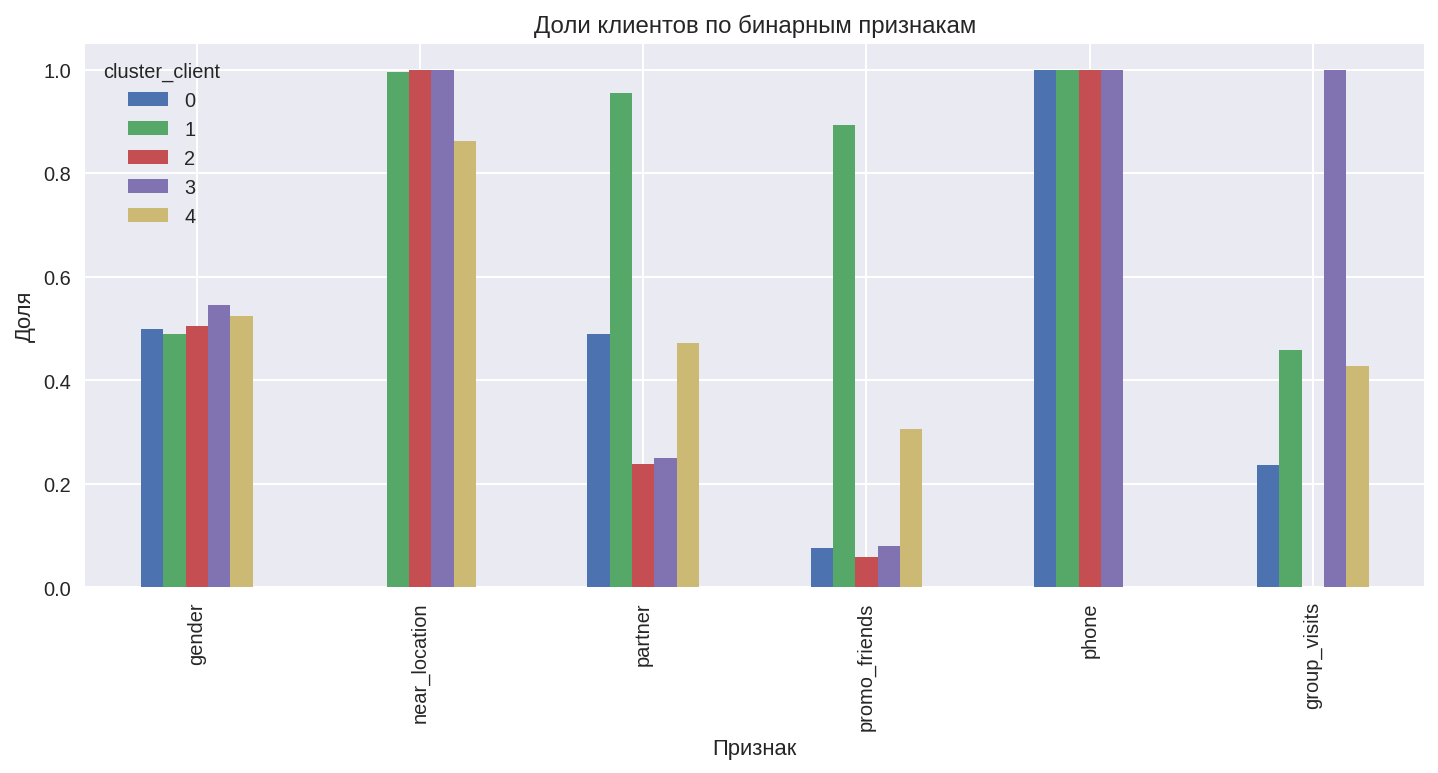

In [15]:
# построение распределения бинарных признаков для кластеров
with plt.style.context('seaborn'):
    df.groupby('cluster_client')[binary_features].agg('mean').T.plot(kind='bar', stacked=False, figsize=(12, 5))
    plt.title('Доли клиентов по бинарным признакам')
    plt.xlabel('Признак')
    plt.ylabel('Доля')    
    plt.show()

Полученные гистограммы наглядно показывают выводы, сделанные по данным признакм на основе средних значений.

Далее построим гистограммы плотностей распределений признаков, у которых может быть больше двух значений.

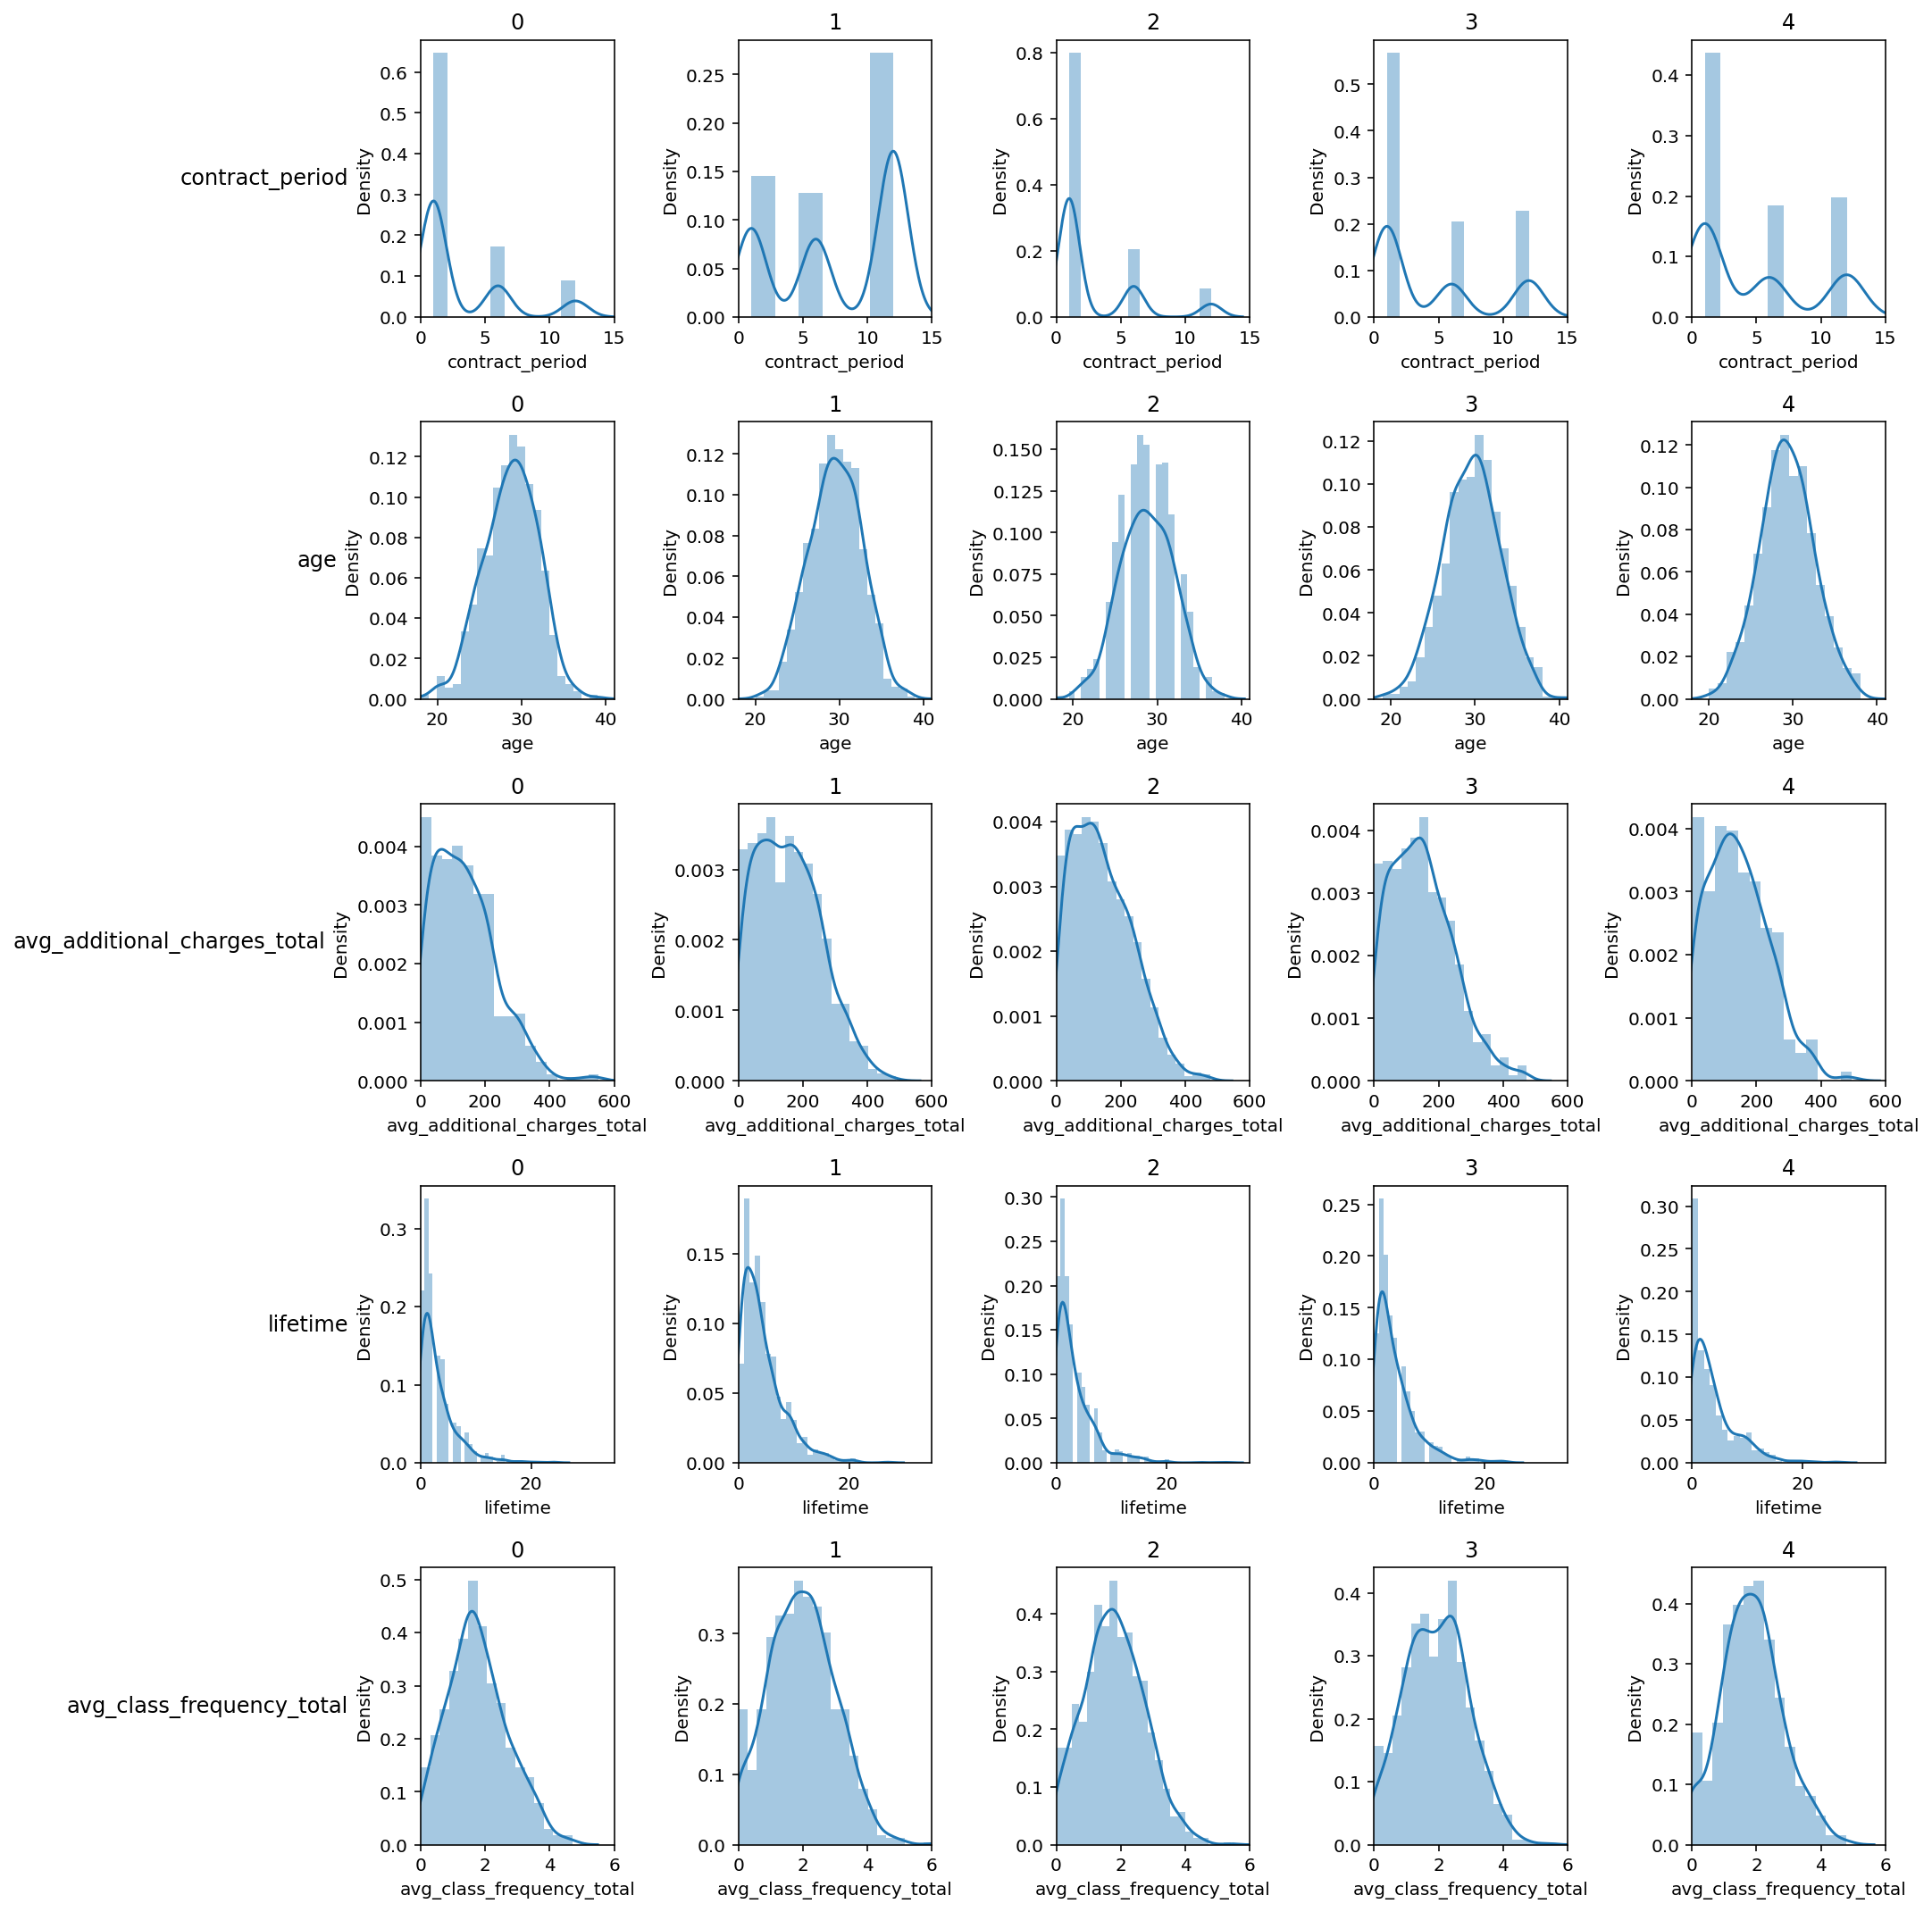

In [16]:
# Формирование списка признаков
num_features = ['contract_period','age','avg_additional_charges_total','lifetime','avg_class_frequency_total']

# Построение гистограмм
fig, axes = plt.subplots(5, 5)
xlimits = [[0, 15],[18, 41],[0, 600],[0, 35],[0, 6]]
i=0
for col in num_features:
    for k in range(5):
        axes[i][k].set_xlim(xlimits[i])
        sns.distplot(df[df['cluster_client']==k][col], ax=axes[i][k])
        axes[i][k].set_title(k)
    i+=1
for ax, row in zip(axes[:,0], num_features):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout()
plt.show()

На основе данных гистограмм можно сделать следующие выводы:

- contract_period
 - клиенты из кластера 1 имеют наиболее долгие контракты, это видно по смещенному вправо распределению;
 - клиенты из кластеров 0 и 2 имеют наименее короткие контракты, это показывают пики на уровне 1-2 месяцев.
 
- age
 - во всех кластерах возраст клиентов практически идентичен, однако видно, что центры распределений в кластерах 1 и 3 смещены правее, ближе к 30 годам.
 
- avg_additional_charges_total
 - в целом графики всех кластеров очень схожи, однако видно что кластеры 1 и 3 имеют чуть более длинный "хвост" вправо, что указывает что они тратят больше и чаще на дополнительные услуги.
 
- lifetime
 - у кластеров 1 и 3 хвост распределения танется до 20 и более месяцев, а в кластерах 0 и 2 видны довольно резкие спады в пределах до 10 месяцев и их "хвост" обрывается не доходя до 20 месяцев.
 
- avg_class_frequency_total
 - для кластеров 0 и 2 распределения смещены левее и пики приходятся на отметки до 2 посещений в неделю, а в кластерах 1 и 3 распределение более плавное и смещено правее отметки в 2 посещения в неделю.

Гистограммы подтвержадют, что кластеры с наименьшим оттоком (1 и 3) характеризуются:

- более долгими контрактами;
- чуть большим возрастом;
- более высокой вовлеченностью клиентов (частота тренировок в неделю, доп.расходы);
- более продолжительным сроком жизни в компании.

Кластеры с наиболее высоким оттоком (0 и 2) характеризуются:
- немного более молодым возрастом;
- имеют менее выраженную вовлеченность;
- чаще имеют короткие контракты.

Построим график с долями оттока по кластерам.

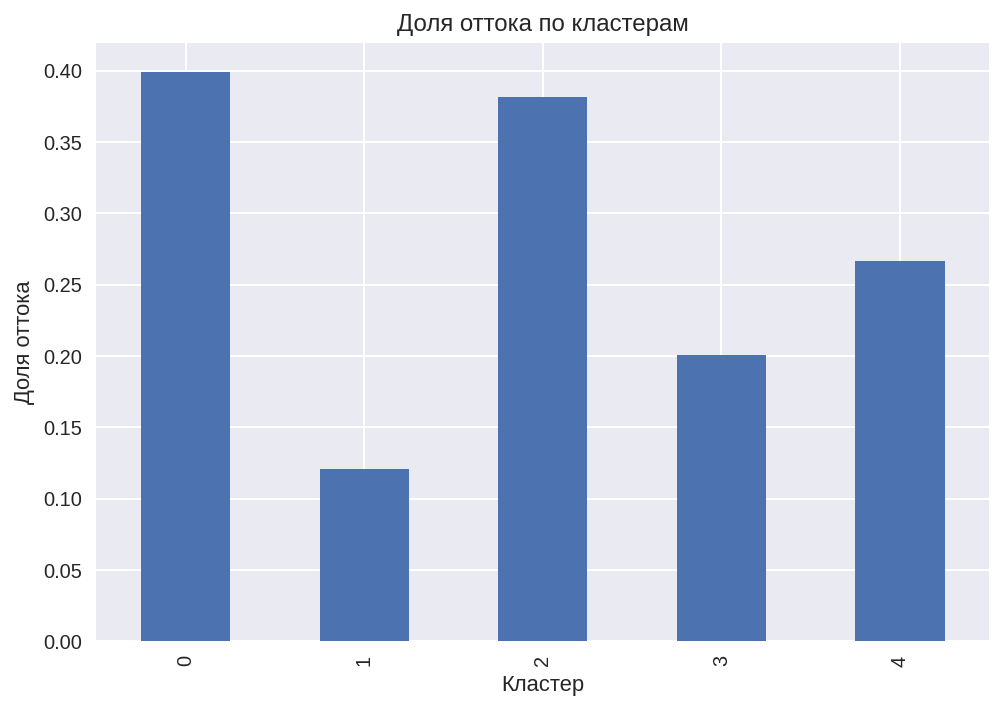

In [17]:
# расчет доли оттока по кластерам
with plt.style.context('seaborn'):
    df.groupby('cluster_client')['churn'].agg('mean').plot(kind='bar')
    plt.title('Доля оттока по кластерам')
    plt.xlabel('Кластер')
    plt.ylabel('Доля оттока')    
    plt.show()

Кластеры 0 и 2 имеют наибольшие доли оттока. Клиенты из этих кластеров в первую очередь требуют принятия мер по удержанию.

Кластер 1 показывает наименьшую долю оттока и включает наиболее лояльных клиентов. 

Кластер 3 также имеет довольно низкую долю оттока. Он включает клиентов с довольно хорошими вовлеченностью и сроком жизни.

Кластер 4 является пограничным и имеет среднюю долю оттока. С данным кластером также можно и нужно работать на удержание.


<b>Промежуточный вывод:</b>

1. На основании дендрограммы видно, что оптимальное количество кластеров — 5. Модель кластеризации на основании алгоритма K-Means была обучена исходя из количества кластеров n=5.

2. Пол (gender) и возраст (age) практически не влияют на отток — они мало различаются между кластерами и не являются определяющими признаками лояльности.

3. Кластеры с наибольшим оттоком — 0 и 2 характеризуются следующими общими чертами:

 - короткие контракты (1–3 мес);
 - низкий lifetime;
 - слабая вовлеченность (редкие визиты, отсутствие участия в групповых тренировках, партнёрских и реферальных программах);
 - большинство живут/работают далеко от фитнес-центров.

Эти клиенты являются наиболее уязвимыми, с высоким риском оттока.


4. Кластеры с наименьшим оттоком — 1 и 3 характеризуются следующими общими чертами:

 - более долгие контракты (4.5–7.7 мес);

 - высокий lifetime (20+ мес);

 - высокая вовлечённость (регулярные посещения, участие в групповых тренировках, акциях);

 - живут или работают рядом с клубами.

Эти клиенты являются лояльной аудиторией.

5. Кластер 4 — промежуточный сегмент, который характеризуется средней вовлеченностью и долей оттока. Данный кластер имеет потенциал быть переведённым в более лояльную категорию при правильной работе по удержанию (персональные предложения, акции, вовлечение в групповые тренировки).


6. Общие факторы, повышающие лояльность и снижающие отток:

 - долгосрочные контракты;
 - частое посещение клуба (более 2 раз в неделю);
 - участие в групповых тренировках;
 - проживание или работа рядом с фитнес-центром;
 - участие в реферальных и партнёрских программах;
 - большее использование дополнительных платных услуг.

## Выводы и рекомендации

<b>Выводы:</b>
    
1. Анализ факторов, влияющих на отток клиентов, проведенный с помощью анализа признаков и кластеризации, показал что наиболее значимыми признаками оказались:

 - срок жизни клиента (lifetime);
 - частота посещений, особенно в текущем месяце;
 - продолжительность и остаток контракта;
 - вовлечённость в дополнительные активности (групповые занятия, партнёрские программы, акции).

2. Около половины клиентов уходят уже в первый месяц, особенно при краткосрочных контрактах. Это подчёркивает важность вовлечения новых клиентов в первые недели после подписки.

3. Сформированы пять кластеров клиентов, каждый из которых отличается по уровню вовлеченности и вероятности оттока:

 - Кластеры 0 и 2 — наиболее уязвимые сегменты с высоким уровнем оттока. Общие черты: короткие контракты, низкий lifetime, слабая вовлеченность и удалённость от клуба.
 - Кластеры 1 и 3 — лояльные клиенты с высоким уровнем вовлеченности, долгосрочными контрактами и частыми посещениями. Они составляют основу удержания.
 - Кластер 4 — переходная группа, которую можно перевести в лояльные при правильной работе по удержанию.

4. Пол и возраст имеют незначительное влияние на отток и могут быть исключены из приоритетных факторов при таргетировании.


<b>Рекомендации по работе с сегментами:</b>

1. Для кластеров 1 и 3: поддерживать вовлечённость и использовать данные кластеры как референс-модель для разработки мер по удержанию других клиентов.

2. Для кластеров 0 и 2: привлечение клиентов в  групповые занятия, скидочные программы за продления абонементов,  продвижение участия в программах лояльности (акция "приведи друга" и партнерская программа показали хорошие результаты). Также стоит проанализировать причины уходя клиентов и возможно изменить (персонализировать) подход к новым клиентам;

3. Для кластера 4: рекомендуется более детальный анализ с целью выявления клиентов, склоняющихся к оттоку, для повышения удержания рекомендуется разработать и протестировать персональные предложения, увеличить вовлечение в акции и  групповые тренировки.